## Trip Advisor Hotel Review Prediction

### References:

1.https://www.kaggle.com/ruchi798/how-do-you-recognize-fake-news

2.https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb

In this kernel,I am going to do an analysis on the hotel reviews from Trip advisor dataset.The ratings scale is from 1-5 and there are 20491 reviews provided.

#### Approach:

I plan to do an n-gram and word cloud analysis to find out if the reviews could be easily differentiated with respect to their ratings.Then I plan to build basic models -TFIDF,Count vectorizer with either Logit or RandomForest.This is a multi-class classification problem.

### Loading the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import string
from nltk.corpus import stopwords
import spacy
from wordcloud import WordCloud

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss,f1_score,confusion_matrix,plot_confusion_matrix
from scipy.sparse import hstack,csr_matrix
from tqdm import tqdm
import operator

In [3]:
#data=pd.read_csv('../data/tripadvisor_hotel_reviews.csv')
data=pd.read_csv('../input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv')

In [4]:
data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [5]:
data.shape

(20491, 2)

### Data Cleaning and handling missing values (if any)

In [6]:
data.isna().sum()

Review    0
Rating    0
dtype: int64

There are no null values in either of the columns.

Text(0, 0.5, 'Count')

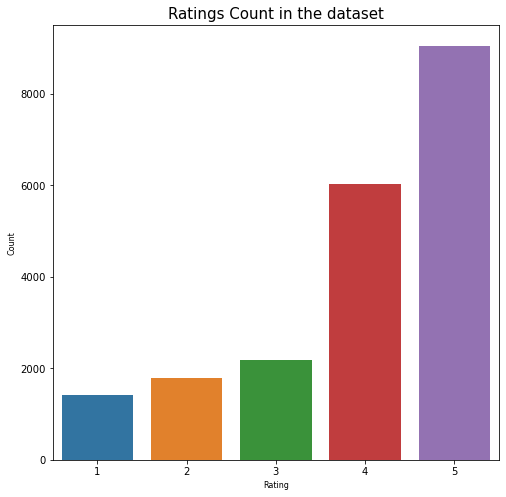

In [7]:
plt.figure(figsize=(8,8))
sns.countplot(data['Rating'])
plt.title('Ratings Count in the dataset',fontsize=15)
plt.xlabel('Rating',fontsize=8)
plt.ylabel('Count',fontsize=8)

In [8]:
(data['Rating'].value_counts()/data.shape[0])*100

5    44.185252
4    29.471475
3    10.658338
2     8.750183
1     6.934752
Name: Rating, dtype: float64

In [9]:
list(data['Review'])[:3]

['nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  ',
 'ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom un

44 % of the dataset has reviews with rating 5 while 29 % of the datset has reviews with rating 4.

## n-gram Analysis

In [10]:
stopwrds=set(stopwords.words("english"))

In [11]:
#https://www.kaggle.com/ruchi798/how-do-you-recognize-fake-news
def get_bigram(df,n):
   
    vec=CountVectorizer(ngram_range=(2,2),stop_words=stopwrds).fit(df)
    bag_of_words=vec.transform(df)
    sum_words=bag_of_words.sum(0)
    word_freq=[(word,sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    word_freq=sorted(word_freq,key=lambda x:x[1],reverse=True)
    return word_freq[:n]

In [12]:
bigram_rat1=get_bigram(data.loc[data['Rating']==1,'Review'].apply(lambda x:" ".join(sent for sent in x.split() if sent not in ['did','not','hotel','room','does'])),10)
bigram_rat1

[('punta cana', 151),
 ('credit card', 114),
 ('customer service', 108),
 ('stay away', 80),
 ('air conditioning', 78),
 ('travel agent', 66),
 ('san juan', 62),
 ('hot water', 61),
 ('desk staff', 57),
 ('new orleans', 54)]

In [13]:
bigram_rat2=get_bigram(data.loc[data['Rating']==2,'Review'].apply(lambda x:" ".join(sent for sent in x.split() if sent not in ['did','not','hotel','room','does'])),10)
bigram_rat2

[('punta cana', 201),
 ('air conditioning', 142),
 ('staff friendly', 128),
 ('san juan', 100),
 ('great location', 97),
 ('make sure', 89),
 ('stayed nights', 88),
 ('good location', 78),
 ('customer service', 75),
 ('non smoking', 73)]

In [14]:
bigram_rat3=get_bigram(data.loc[data['Rating']==3,'Review'].apply(lambda x:" ".join(sent for sent in x.split() if sent not in ['did','not','hotel','room','does'])),10)
bigram_rat3

[('great location', 251),
 ('staff friendly', 242),
 ('punta cana', 207),
 ('good location', 176),
 ('stayed nights', 146),
 ('walking distance', 135),
 ('san juan', 130),
 ('good value', 122),
 ('location great', 114),
 ('make sure', 114)]

In [15]:
bigram_rat4=get_bigram(data.loc[data['Rating']==4,'Review'].apply(lambda x:" ".join(sent for sent in x.split() if sent not in ['did','not','hotel','room','does'])),10)
bigram_rat4

[('great location', 845),
 ('staff friendly', 763),
 ('punta cana', 565),
 ('walking distance', 528),
 ('friendly helpful', 503),
 ('staff helpful', 416),
 ('good value', 414),
 ('stayed nights', 409),
 ('minute walk', 402),
 ('great time', 401)]

In [16]:
bigram_rat5=get_bigram(data.loc[data['Rating']==5,'Review'].apply(lambda x:" ".join(sent for sent in x.split() if sent not in ['did','not','hotel','room','does'])),10)
bigram_rat5

[('great location', 1014),
 ('staff friendly', 1013),
 ('friendly helpful', 777),
 ('highly recommend', 736),
 ('walking distance', 735),
 ('punta cana', 603),
 ('staff helpful', 540),
 ('place stay', 540),
 ('stayed nights', 511),
 ('minute walk', 511)]

In [17]:
## Check for common words in highest rated reviews
set([x[0] for x in bigram_rat3])\
&set([x[0] for x in bigram_rat4])\
&set([x[0] for x in bigram_rat5])

{'great location',
 'punta cana',
 'staff friendly',
 'stayed nights',
 'walking distance'}

In [18]:
#Check for common words in least rated reviews
set([x[0] for x in bigram_rat1])&set([x[0] for x in bigram_rat2])&set([x[0] for x in bigram_rat3])


{'punta cana', 'san juan'}

Analysis of the bigrams for the ratings provides us the following insight:

1.There are bigrams which are more common in all the reviews.

2.great location,staff friendly,staff helpful,stayed nights,walking nights were more pronunced as the rating moves from 3 to 5 whereas stay away,customer service,make sure were few bigrams which were seen in reviews with rating 1-3.

4.Punta cana and San Juan are names of places which were found in almost all of the reviews irrespective of the rating.

For trigram analysis,Lets remove these common location names and check the corpus.

In [19]:
def get_trigram(df,n):
   
    vec=CountVectorizer(ngram_range=(3,3),stop_words=stopwrds).fit(df)
    bag_of_words=vec.transform(df)
    sum_words=bag_of_words.sum(0)
    word_freq=[(word,sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    word_freq=sorted(word_freq,key=lambda x:x[1],reverse=True)
    return word_freq[:n]

In [20]:
trigram_rat1=get_trigram(data.loc[data['Rating']==1,'Review'].apply(lambda x:" ".join(sent for sent in x.split() if sent not in ['did','not','hotel','room','does','san','juan','punta','cana'])),10)
trigram_rat1

[('year old son', 14),
 ('king size bed', 13),
 ('melia caribe tropical', 12),
 ('holiday inn express', 10),
 ('staff extremely rude', 10),
 ('credit card details', 10),
 ('called desk told', 9),
 ('make matters worse', 9),
 ('reviews trip advisor', 9),
 ('long story short', 9)]

In [21]:
trigram_rat2=get_trigram(data.loc[data['Rating']==2,'Review'].apply(lambda x:" ".join(sent for sent in x.split() if sent not in ['did','not','hotel','room','does','san','juan','punta','cana'])),10)
trigram_rat2

[('king size bed', 29),
 ('staff friendly helpful', 24),
 ('reviews trip advisor', 15),
 ('la carte restaurants', 13),
 ('good value money', 12),
 ('coffee making facilities', 11),
 ('free internet access', 10),
 ('10 minute walk', 10),
 ('non smoking rooms', 10),
 ('let start saying', 10)]

In [22]:
trigram_rat3=get_trigram(data.loc[data['Rating']==3,'Review'].apply(lambda x:" ".join(sent for sent in x.split() if sent not in ['did','not','hotel','room','does','san','juan','punta','cana'])),10)
trigram_rat3

[('staff friendly helpful', 54),
 ('king size bed', 32),
 ('good value money', 31),
 ('10 minute walk', 29),
 ('flat screen tv', 27),
 ('la carte restaurants', 20),
 ('good location stayed', 18),
 ('15 minute walk', 17),
 ('clean staff friendly', 17),
 ('red light district', 17)]

In [23]:
trigram_rat4=get_trigram(data.loc[data['Rating']==4,'Review'].apply(lambda x:" ".join(sent for sent in x.split() if sent not in ['did','not','hotel','room','does','san','juan','punta','cana'])),10)
trigram_rat4

[('staff friendly helpful', 298),
 ('good value money', 125),
 ('10 minute walk', 99),
 ('great place stay', 98),
 ('flat screen tv', 89),
 ('easy walking distance', 85),
 ('la carte restaurants', 85),
 ('king size bed', 73),
 ('staff helpful friendly', 68),
 ('free internet access', 68)]

In [24]:
trigram_rat5=get_trigram(data.loc[data['Rating']==5,'Review'].apply(lambda x:" ".join(sent for sent in x.split() if sent not in ['did','not','hotel','room','does','san','juan','punta','cana'])),10)
trigram_rat5

[('staff friendly helpful', 403),
 ('great place stay', 169),
 ('flat screen tv', 151),
 ('king size bed', 114),
 ('10 minute walk', 114),
 ('staff helpful friendly', 104),
 ('great location great', 100),
 ('free internet access', 100),
 ('easy walking distance', 96),
 ('staff extremely helpful', 94)]

In [25]:
## Check for common words in highest rated reviews
set([x[0] for x in trigram_rat3])\
&set([x[0] for x in trigram_rat4])\
&set([x[0] for x in trigram_rat5])

{'10 minute walk', 'flat screen tv', 'king size bed', 'staff friendly helpful'}

In [26]:
## Check for common words in least rated reviews
set([x[0] for x in trigram_rat1])\
&set([x[0] for x in trigram_rat2])\
&set([x[0] for x in trigram_rat3])

{'king size bed'}

Similar to bigram analysis,trigram analysis presents us imporant insights:

1.There are common words in highest rated reviews among the top 10 most common words. - 10 minute walk,flat screen tv,staff friendly helpful are a few.

2.King size bed is the common trigram which appears in all the reviews across the rating.

From the n-gram analysis of words,it is seen that there are many words which appear across the reviews and this is a challenge since it might make our model difficult to distinguish between the ratings.

Lets see if we can find any difference in the length,number of words etc across the rating.

### Feature Engineering

In [27]:
data['length']=data['Review'].apply(lambda x:len(x.split()))
data['num_chars']=data['Review'].apply(lambda x:len(str(x)))
data['num_punctuations']=data['Review'].apply(lambda x:len([c for c in x if x in string.punctuation]))
data['num_stopwords']=data['Review'].apply(lambda x:len([c for c in str(x).lower().split() if c in stopwrds]))

Text(0, 0.5, 'Num Stopwords')

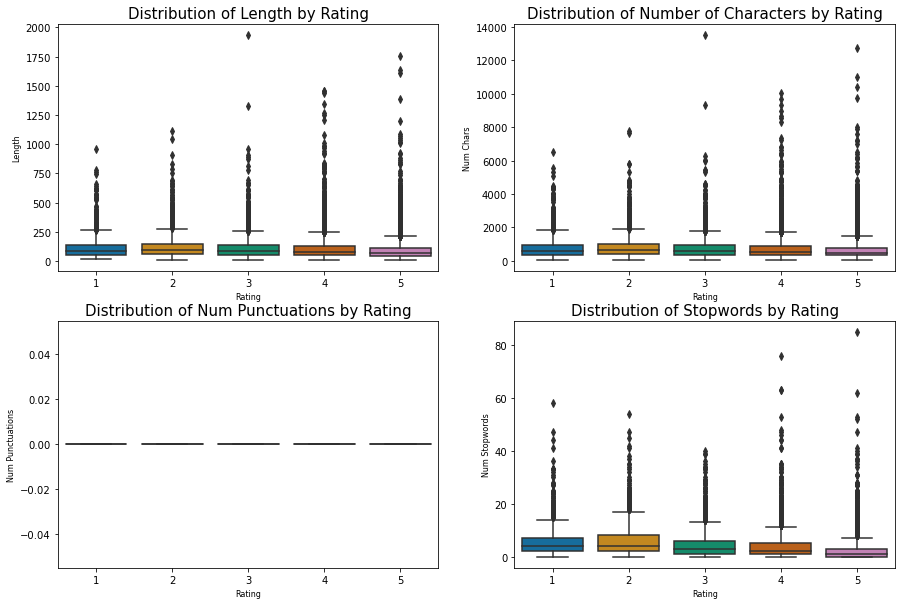

In [28]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.boxplot(x='Rating',y='length',data=data,palette=sns.color_palette('colorblind'))
plt.title('Distribution of Length by Rating',fontsize=15)
plt.xlabel('Rating',fontsize=8)
plt.ylabel('Length',fontsize=8)
plt.subplot(2,2,2)
sns.boxplot(x='Rating',y='num_chars',data=data,palette=sns.color_palette('colorblind'))
plt.title('Distribution of Number of Characters by Rating',fontsize=15)
plt.xlabel('Rating',fontsize=8)
plt.ylabel('Num Chars',fontsize=8)
plt.subplot(2,2,3)
sns.boxplot(x='Rating',y='num_punctuations',data=data,palette=sns.color_palette('colorblind'))
plt.title('Distribution of Num Punctuations by Rating',fontsize=15)
plt.xlabel('Rating',fontsize=8)
plt.ylabel('Num Punctuations',fontsize=8)
plt.subplot(2,2,4)
sns.boxplot(x='Rating',y='num_stopwords',data=data,palette=sns.color_palette('colorblind'))
plt.title('Distribution of Stopwords by Rating',fontsize=15)
plt.xlabel('Rating',fontsize=8)
plt.ylabel('Num Stopwords',fontsize=8)

* There is a slight difference in the median length of the reviews with respect to each rating.But the difference is not pronunced much.Rating 5 has lesser median value compared to other ratings.

* Similarly when the number of characters is considered,rating 5 has a smaller median value compared to other.But the difference is not easily distinguishable.

* An empty plot for the punctuation indicates that there are no reviews having punctuations !!! Strange ..

* The number of stopwords with respect to each rating is also dominated by lot of outliers.Those providing ratings of 5 are using more stopwords compared to other ratings.

## Basic Modelling

In [29]:
kf=StratifiedKFold(n_splits=5,random_state=42,shuffle=True)

In [30]:
feat=['length', 'num_chars', 'num_punctuations', 'num_stopwords']

In [31]:
encoding_dict={1:0,
              2:1,
              3:2,
              4:3,
              5:4}
data['Rating']=data['Rating'].map(encoding_dict)

In [32]:
data['Rating'].value_counts()

4    9054
3    6039
2    2184
1    1793
0    1421
Name: Rating, dtype: int64

In [33]:
nlp=spacy.load('en_core_web_sm',disable=['ner','parser','tagger'])

def spacy_tokenizer(text):
    tokens=[x.text for x in nlp(text)]
    tokens=[tok.strip() for tok in tokens]
    ## remove most common terms identified from n-gram analysis,
    tokens=[tok for tok in tokens if tok!='' and tok not in ['did','not','hotel','room','does','san','juan','punta','cana']]
    return tokens

## Using TF-IDF and Random Forest Model

In [34]:
oof_preds_tfidf=np.zeros((len(data),1))
for i,(trn_idx,val_idx) in enumerate(kf.split(data['Review'],data['Rating'])):
    print(f'Fold {i+1} Training ...')
    train_x=data.iloc[trn_idx,].reset_index(drop=True)
    valid_x=data.iloc[val_idx,].reset_index(drop=True)
    train_y=data.iloc[trn_idx,1].values
    valid_y=data.iloc[val_idx,1].values
    
    word_vectorizer=TfidfVectorizer(analyzer='word',tokenizer=spacy_tokenizer,
                       token_pattern=r'\w{1,}',
                       stop_words=stopwrds,
                      ngram_range=(1,3),max_features=8000)
    
    word_vectorizer.fit(list(train_x['Review'].values))
    train_word_vec=word_vectorizer.transform(list(train_x['Review']))
    valid_word_vec=word_vectorizer.transform(list(valid_x['Review']))
    train_x_sparse=hstack((csr_matrix(train_x[feat]),train_word_vec))
    valid_x_sparse=hstack((csr_matrix(valid_x[feat]),valid_word_vec))
    rf=RandomForestClassifier(n_estimators=500,
                             max_depth=20,
                             max_features='auto',
                             min_samples_split=5,
                             bootstrap=True,
                             n_jobs=-1,
                             random_state=42,
                             verbose=False)
    rf.fit(train_x_sparse,train_y)
    preds=rf.predict(valid_x_sparse)
    score=f1_score(valid_y,preds,average='macro')
    print(f'Fold {i+1} f1 score {score}')
    oof_preds_tfidf[val_idx]=preds.reshape(-1,1)
oof_score_tfidf=f1_score(data['Rating'],oof_preds_tfidf.astype('int'),average='macro')
print(f'Overall OOF f1 score {oof_score_tfidf}')

Fold 1 Training ...
Fold 1 f1 score 0.25582635768998585
Fold 2 Training ...
Fold 2 f1 score 0.24485567000494543
Fold 3 Training ...
Fold 3 f1 score 0.24648984423464518
Fold 4 Training ...
Fold 4 f1 score 0.24691691595672466
Fold 5 Training ...
Fold 5 f1 score 0.2412705553976206
Overall OOF f1 score 0.24708040498480938


### Using Count Vectorizer and Random Forest

In [35]:
oof_preds_cv=np.zeros((len(data),1))
for i,(trn_idx,val_idx) in enumerate(kf.split(data['Review'],data['Rating'])):
    print(f'Fold {i+1} Training ...')
    train_x=data.iloc[trn_idx,].reset_index(drop=True)
    valid_x=data.iloc[val_idx,].reset_index(drop=True)
    train_y=data.iloc[trn_idx,1].values
    valid_y=data.iloc[val_idx,1].values
    
    count_vectorizer=CountVectorizer(analyzer='word',tokenizer=spacy_tokenizer,
                       token_pattern=r'\w{1,}',
                       stop_words=stopwrds,
                      ngram_range=(1,3),max_features=8000)
    
    count_vectorizer.fit(list(train_x['Review'].values))
    train_word_vec=count_vectorizer.transform(list(train_x['Review']))
    valid_word_vec=count_vectorizer.transform(list(valid_x['Review']))
    train_x_sparse=hstack((csr_matrix(train_x[feat]),train_word_vec))
    valid_x_sparse=hstack((csr_matrix(valid_x[feat]),valid_word_vec))
    rf=RandomForestClassifier(n_estimators=500,
                             max_depth=20,
                             max_features='auto',
                             min_samples_split=5,
                             bootstrap=True,
                             n_jobs=-1,
                             random_state=42,
                             verbose=False)
    rf.fit(train_x_sparse,train_y)
    preds=rf.predict(valid_x_sparse)
    score=f1_score(valid_y,preds,average='macro')
    print(f'Fold {i+1} f1 score {score}')
    oof_preds_cv[val_idx]=preds.reshape(-1,1)
oof_score_cv=f1_score(data['Rating'],oof_preds_cv.astype('int'),average='macro')
print(f'Overall OOF f1 score {oof_score_cv}')

Fold 1 Training ...
Fold 1 f1 score 0.2512028165902196
Fold 2 Training ...
Fold 2 f1 score 0.24022727697981772
Fold 3 Training ...
Fold 3 f1 score 0.25537408282538204
Fold 4 Training ...
Fold 4 f1 score 0.24996516439519373
Fold 5 Training ...
Fold 5 f1 score 0.25051643744568103
Overall OOF f1 score 0.24948795293654297
